In [31]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import pymc3 as pm
import pandas as pd

%matplotlib inline
sns.set(font_scale=1.5)

In [32]:
tips = sns.load_dataset('tips')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


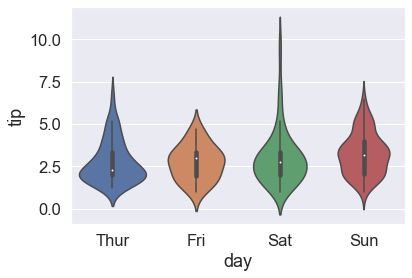

In [33]:
sns.violinplot(x='day', y='tip', data=tips)

In [34]:
y = tips['tip'].values
idx = pd.Categorical(tips['day']).codes

In [35]:
with pm.Model() as comparing_groups:
    means = pm.Normal('means', mu=0, sd=10, shape=len(set(idx)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(idx)))
    ymod = pm.Normal('y', mu=means[idx], sd=sds[idx], observed=y)
    trace_cg = pm.sample(5000, chains=4)
chain_cg = trace_cg[100::]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sds, means]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:21<00:00, 1031.61draws/s]


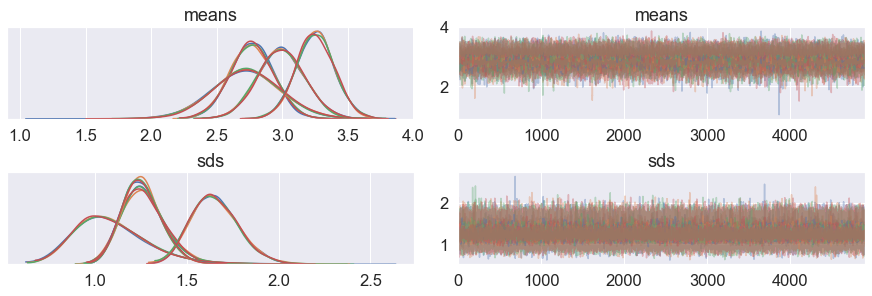

In [36]:
pm.traceplot(chain_cg, compact=True);

In [37]:
pm.summary(chain_cg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
means__0,2.769470,0.164162,0.001191,2.450664,3.094762,20487.741013,1.000025
means__1,2.728748,0.257135,0.001787,2.218010,3.230655,19999.473243,1.000238
means__2,2.992392,0.178253,0.001303,2.652123,3.349328,21213.434452,1.000062
means__3,3.252846,0.144421,0.000923,2.965778,3.533420,21507.091147,0.999900
sds__0,1.266746,0.119227,0.000702,1.049531,1.514090,21763.515047,1.000020
sds__1,1.097054,0.202589,0.001541,0.743856,1.491309,18955.123009,0.999950
sds__2,1.654803,0.128529,0.000785,1.414176,1.912909,21985.291053,1.000025
sds__3,1.256574,0.105162,0.000749,1.057063,1.464523,20795.072014,0.999907


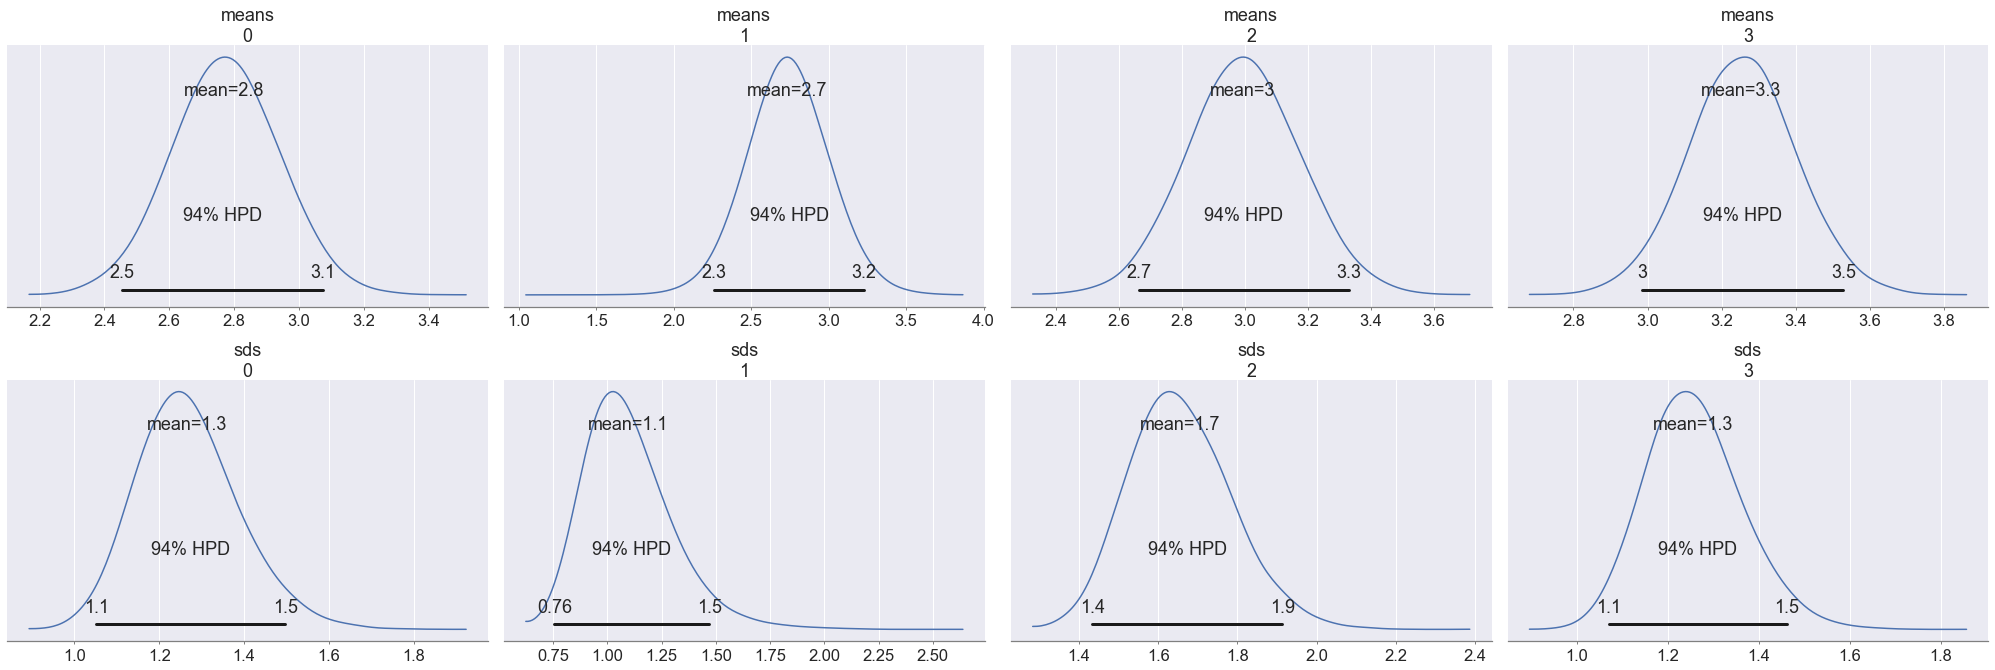

In [40]:
pm.plot_posterior(chain_cg);

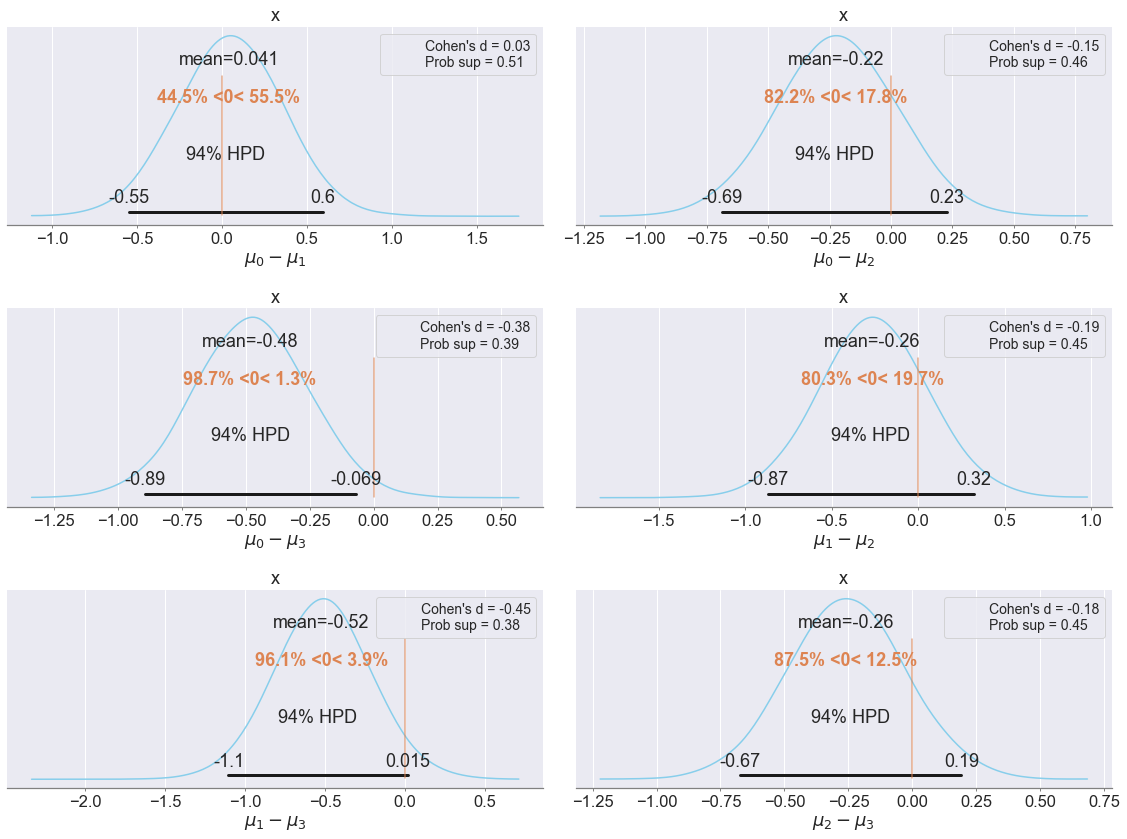

In [38]:
dist = dist = stats.norm()
_, ax = plt.subplots(3, 2, figsize=(16, 12))

comparisons = [(i,j) for i in range(4) for j in range(i+1, 4)]
pos = [(k,l) for k in range(3) for l in (0, 1)]

for (i, j), (k,l) in zip(comparisons, pos):
    means_diff = chain_cg['means'][:,i]-chain_cg['means'][:,j]
    d_cohen = (means_diff / np.sqrt((chain_cg['sds'][:,i]**2 + chain_cg['sds'][:,j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    pm.plot_posterior(means_diff, ref_val=0, ax=ax[k, l],
    color='skyblue')
    ax[k, l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps) ,alpha=0)
    ax[k, l].set_xlabel('$\mu_{}-\mu_{}$'.format(i, j),
    fontsize=18)
    ax[k,l ].legend(loc='upper right', fontsize=14)
    plt.tight_layout()

## Make more robust to outliers
Ch 3 ex 3

In [41]:
with pm.Model() as comparing_groups:
    mu = pm.Flat('flat')
    means = pm.Normal('means', mu=mu, sd=10, shape=len(set(idx)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(idx)))
    ymod = pm.Normal('y', mu=means[idx], sd=sds[idx], observed=y)
    trace_cg = pm.sample(5000, chains=4)
chain_cg = trace_cg[100::]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sds, means, flat]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:23<00:00, 922.93draws/s] 


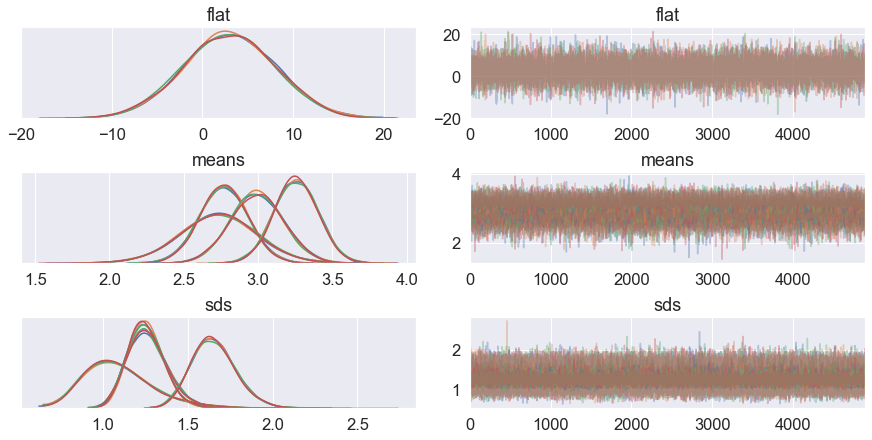

In [42]:
pm.traceplot(chain_cg, compact=True);

In [43]:
pm.summary(chain_cg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
flat,2.996926,4.993300,0.030755,-6.573869,12.813731,21607.192257,1.000119
means__0,2.770053,0.160629,0.001088,2.452875,3.087990,19737.663981,1.000007
means__1,2.733703,0.257892,0.001898,2.214918,3.234830,18585.474864,0.999939
means__2,2.993747,0.176858,0.001209,2.635230,3.330122,20775.387099,0.999952
means__3,3.255878,0.145955,0.001064,2.968287,3.539172,20212.173776,0.999904
sds__0,1.264889,0.117504,0.000920,1.033320,1.488791,18514.793695,0.999976
sds__1,1.098755,0.202806,0.001526,0.745649,1.515239,17894.732050,0.999981
sds__2,1.654820,0.128855,0.000791,1.411166,1.914669,22191.751752,0.999945
sds__3,1.255240,0.104013,0.000736,1.055451,1.455207,20537.535996,0.999907


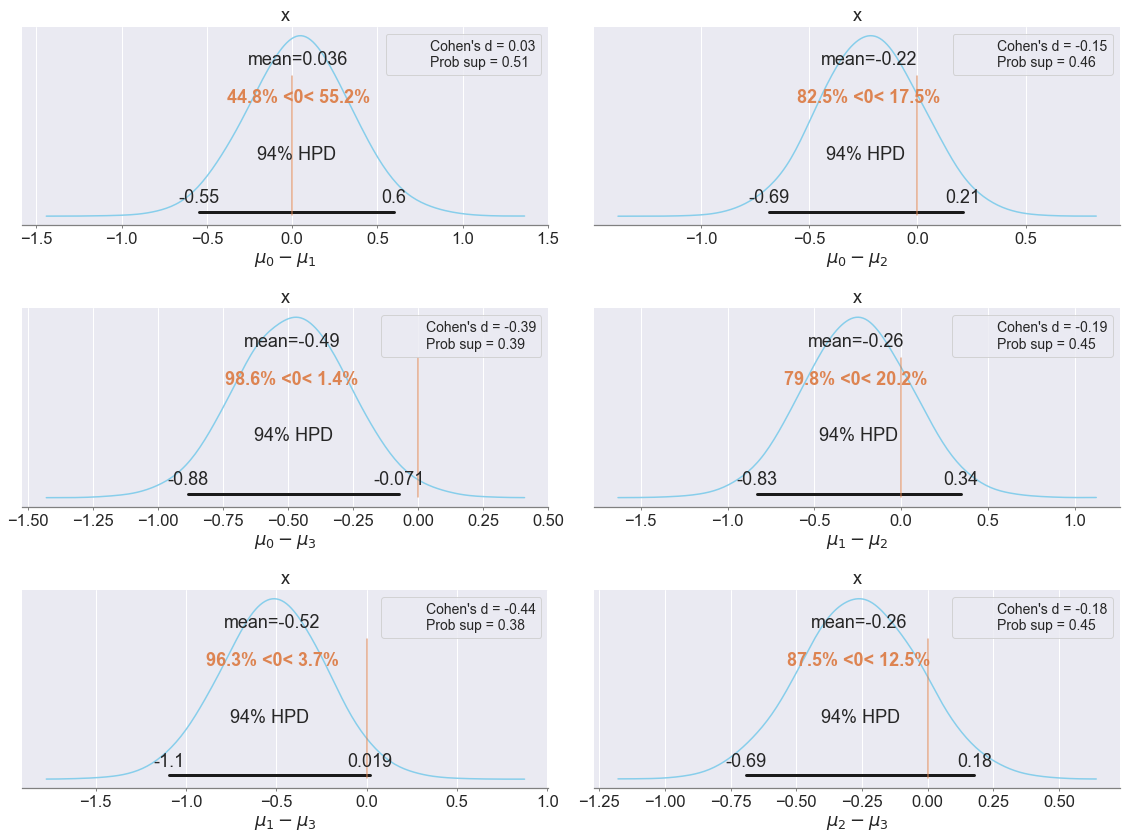

In [44]:
dist = dist = stats.norm()
_, ax = plt.subplots(3, 2, figsize=(16, 12))

comparisons = [(i,j) for i in range(4) for j in range(i+1, 4)]
pos = [(k,l) for k in range(3) for l in (0, 1)]

for (i, j), (k,l) in zip(comparisons, pos):
    means_diff = chain_cg['means'][:,i]-chain_cg['means'][:,j]
    d_cohen = (means_diff / np.sqrt((chain_cg['sds'][:,i]**2 + chain_cg['sds'][:,j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    pm.plot_posterior(means_diff, ref_val=0, ax=ax[k, l],
    color='skyblue')
    ax[k, l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps) ,alpha=0)
    ax[k, l].set_xlabel('$\mu_{}-\mu_{}$'.format(i, j),
    fontsize=18)
    ax[k,l ].legend(loc='upper right', fontsize=14)
    plt.tight_layout()

### Calc the prob of superiority

In [45]:
y_pred = pm.sample_ppc(chain_cg, 100, comparing_groups, size=len(y))

/Users/balarsen/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 100/100 [00:01<00:00, 88.38it/s]


In [48]:
y_pred['y'].shape

(100, 244, 244)

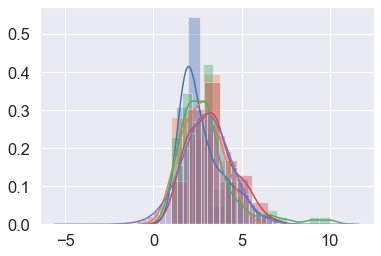

In [61]:
for i in set(idx):
    sns.distplot(y[idx==i])
sns.distplot(y_pred['y'].flatten())
